In [1]:
# Standard Libraries
import math
from sklearn.utils import resample
import pickle
import warnings
# Scientific Computing and Data Manipulation
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.spatial.distance import mahalanobis

# Machine Learning Models and Utilities
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    IsolationForest,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import RFE, SelectFromModel, mutual_info_classif
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import (
    GridSearchCV,
    HalvingRandomSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    cross_val_score,
    learning_curve,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, label_binarize
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier, plot_tree

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Imbalanced Learning
import imblearn
from imblearn.over_sampling import SMOTE

# Parallelization
from joblib import Parallel, delayed

# Google Colab Utilities
from google.colab import drive, files

# Warnings
warnings.filterwarnings('ignore')

# Google Drive Mount
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#%store -r xgb_model
with open('/content/drive/My Drive/IEEE_dataset/xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)
#%store -r filtered_trainDF
filtered_trainDF = pd.read_pickle('/content/drive/My Drive/IEEE_dataset/filtered_trainDF.pkl')
#%store -r testDF
testDF = pd.read_pickle('/content/drive/My Drive/IEEE_dataset/testDF.pkl')

In [3]:
X = filtered_trainDF.drop(columns=['isFraud'])  # Features
y = filtered_trainDF['isFraud']  # Target

for col in X.columns:
    if X[col].dtype == 'datetime64[ns]' or 'Timestamp' in col:
        X[col] = pd.to_datetime(X[col], errors='coerce').astype('int64')  # Convert to timestamp (int)

label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object' or isinstance(X[col].dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric, setting problematic entries to NaN

for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col] = X[col].fillna(X[col].mean())  # Numeric columns: fill with mean
    else:
        X[col] = X[col].fillna(X[col].mode()[0])  # Non-numeric columns: fill with mode

print(X.dtypes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

TransactionID               int64
TransactionDT               int64
TransactionAmt            float64
ProductCD                   int64
card1                       int64
                           ...   
Card_Transaction_Mean     float64
Card_Transaction_Std      float64
Card_Transaction_Count      int64
Fraud_Prob                float64
card4_freq                float64
Length: 450, dtype: object
X_train shape: (423354, 450)
y_train shape: (423354,)


# --------------------------------------------------------------------------------------

# Grid Search Best Estimator Analysis (Don't Run)


In [ ]:
param_grid = {
    'n_estimators': [1, 3, 5],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

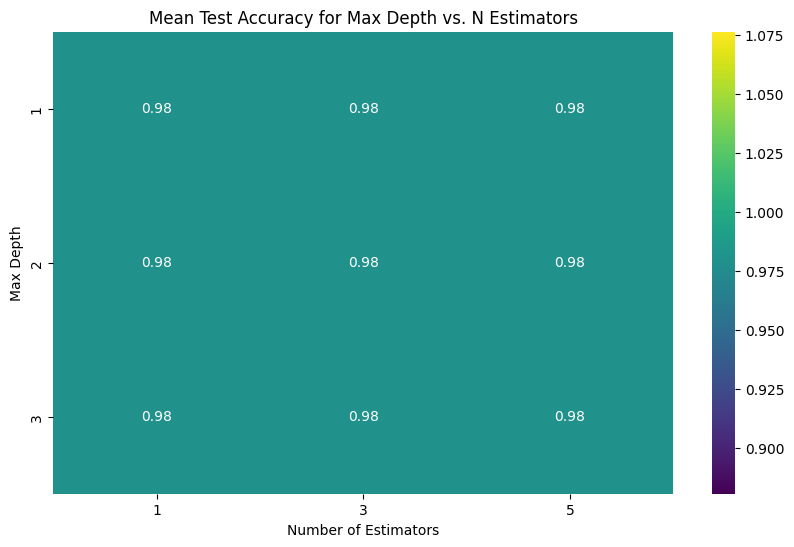

In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot the data for a heatmap (example for 'max_depth' vs 'n_estimators')
pivot_table = results_df.pivot_table(values='mean_test_score',
                                     index='param_max_depth',
                                     columns='param_n_estimators')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Mean Test Accuracy for Max Depth vs. N Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()

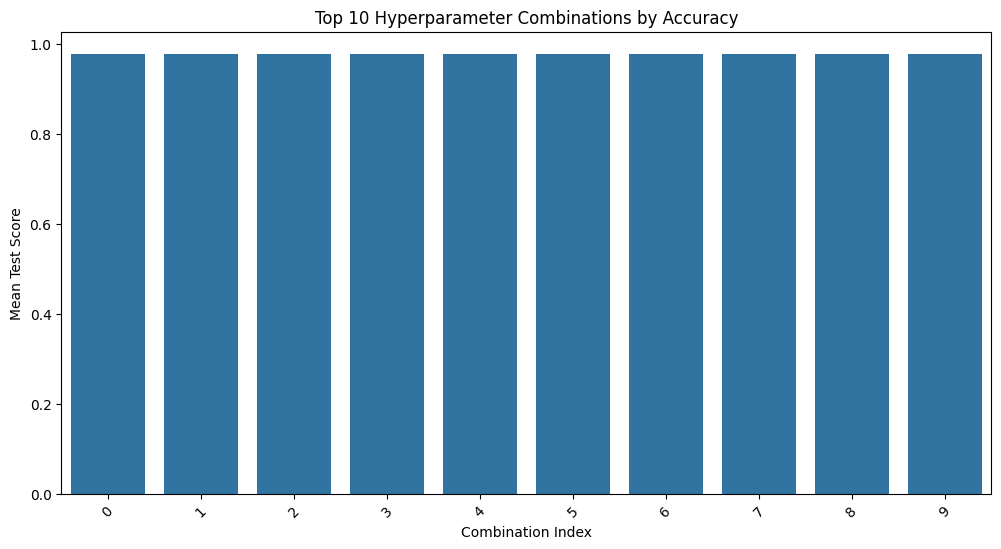

In [ ]:
top_results = results_df.sort_values(by='mean_test_score', ascending=False).head(10)

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_results.index, y=top_results['mean_test_score'])
plt.title('Top 10 Hyperparameter Combinations by Accuracy')
plt.ylabel('Mean Test Score')
plt.xlabel('Combination Index')
plt.xticks(rotation=45)
plt.show()

# --------------------------------------------------------------------------------------

# Top 10 Features Analysis (Don't Run)

In [ ]:
top_n = 10
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(top_n).index

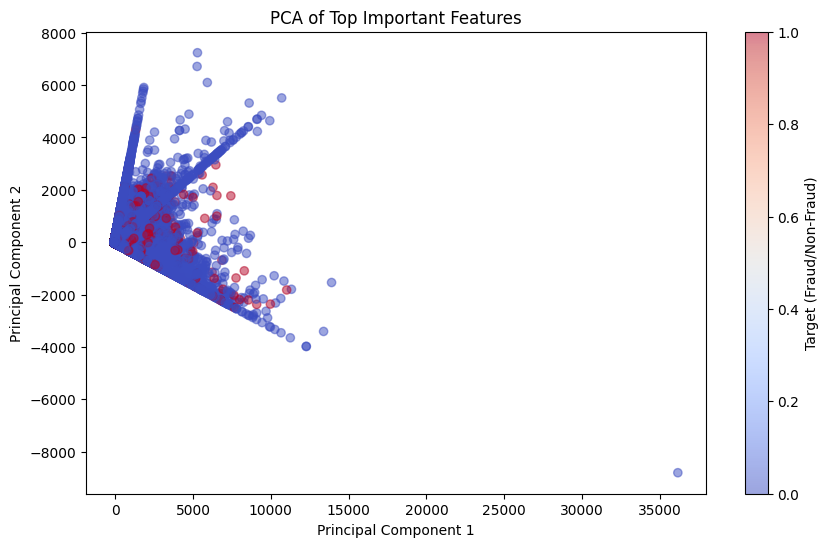

In [ ]:
X_reduced = X[top_features]
pca = PCA(n_components=2)  # Change the number of components as needed
X_pca = pca.fit_transform(X_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Top Important Features')
plt.colorbar(label='Target (Fraud/Non-Fraud)')
plt.show()

In [ ]:
X_train_top_features = X_train[top_features]
X_test_top_features = X_test[top_features]
grid_search_top_features = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search_top_features.fit(X_train_top_features, y_train)

best_model_top_features = grid_search_top_features.best_estimator_
y_pred = best_model_top_features.predict(X_test_top_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the tuned model using top 10 features: {accuracy:.4f}")

Accuracy of the tuned model using top 10 features: 0.9782


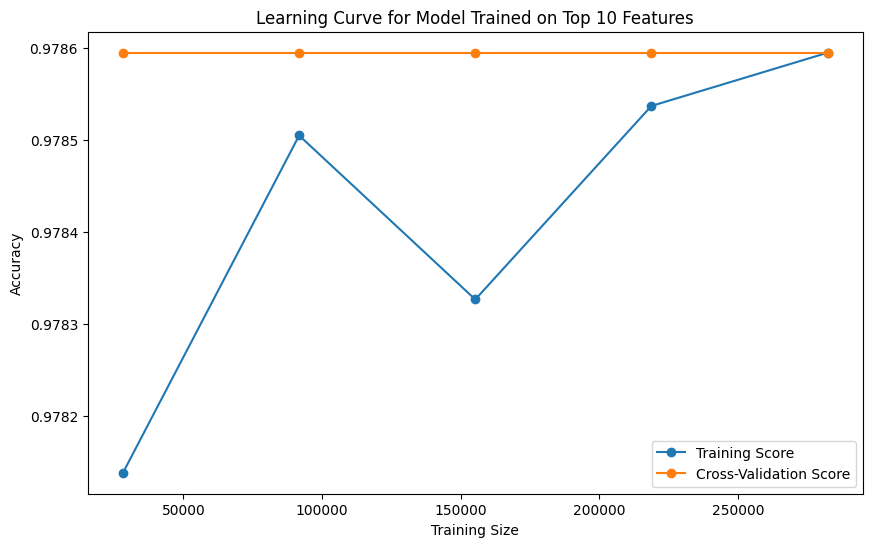

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_model_top_features,
                                                        X_train_top_features,
                                                        y_train, cv=3, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label='Cross-Validation Score')
plt.title('Learning Curve for Model Trained on Top 10 Features')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

Accuracy of XGBoost on combined data: 0.9810


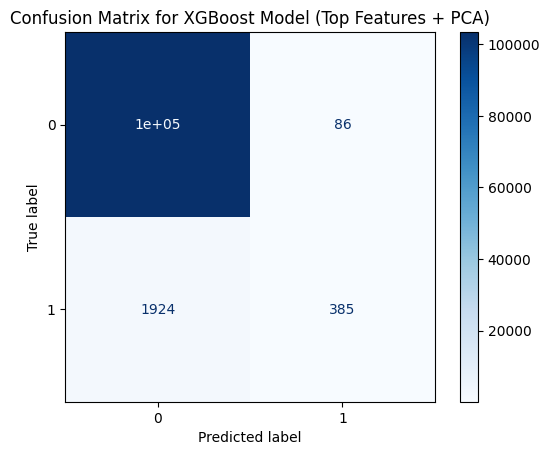

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Combine original top features and PCA components
X_combined = np.hstack([X_reduced, X_pca])

# Split the data
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model_combined = XGBClassifier()
xgb_model_combined.fit(X_train_combined, y_train)

# Generate predictions
y_pred_combined = xgb_model_combined.predict(X_test_combined)

# Calculate accuracy
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f'Accuracy of XGBoost on combined data: {accuracy_combined:.4f}')

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_combined)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model_combined.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for XGBoost Model (Top Features + PCA)')
plt.show()

In [ ]:
print(X_train_combined[0].size)

12


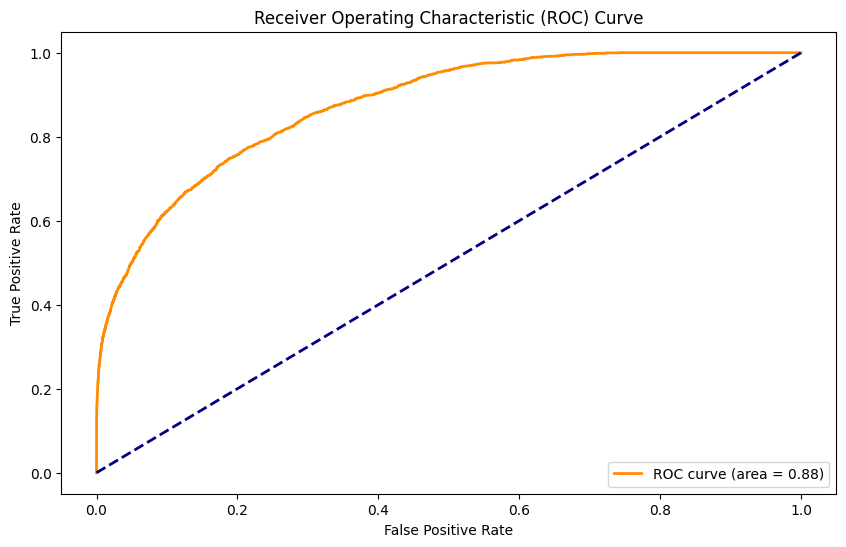

In [ ]:
y_prob = xgb_model_combined.predict_proba(X_test_combined)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

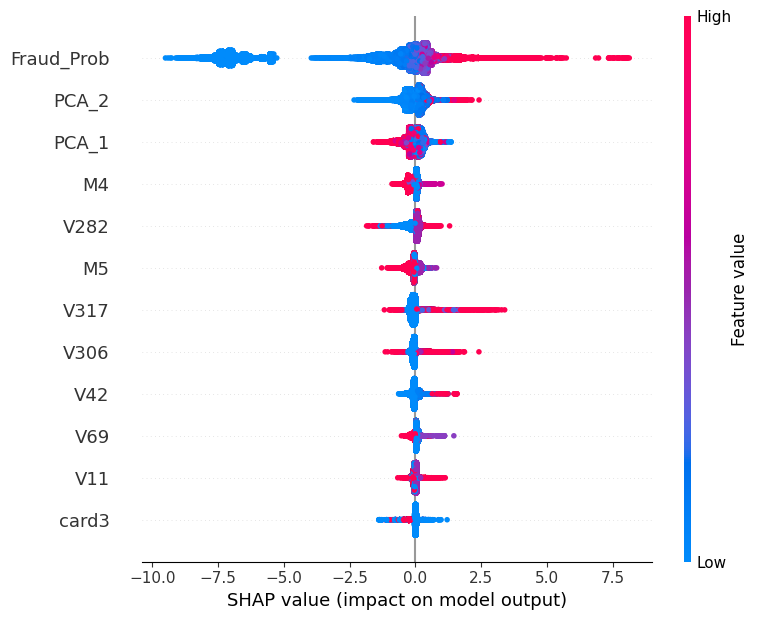

In [ ]:
X_test_combined_df = pd.DataFrame(X_test_combined, columns=list(top_features) + ["PCA_1", "PCA_2"])

# Re-run the SHAP explainer with the DataFrame that includes column names
explainer = shap.TreeExplainer(xgb_model_combined)
shap_values = explainer.shap_values(X_test_combined_df)

# Summary plot with labeled features
shap.summary_plot(shap_values, X_test_combined_df)

# --------------------------------------------------------------------------------------

# Ensemble Method: Stacking + Blending (Don't Run)

In [ ]:
estimators = [
    ('xgb', XGBClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('lr', LogisticRegression())
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train_combined, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf', RandomForestClassifier()),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

Accuracy: 0.9814
Precision: 0.7263
Recall: 0.2391
F1 Score: 0.3597
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    103530
           1       0.73      0.24      0.36      2309

    accuracy                           0.98    105839
   macro avg       0.85      0.62      0.68    105839
weighted avg       0.98      0.98      0.98    105839



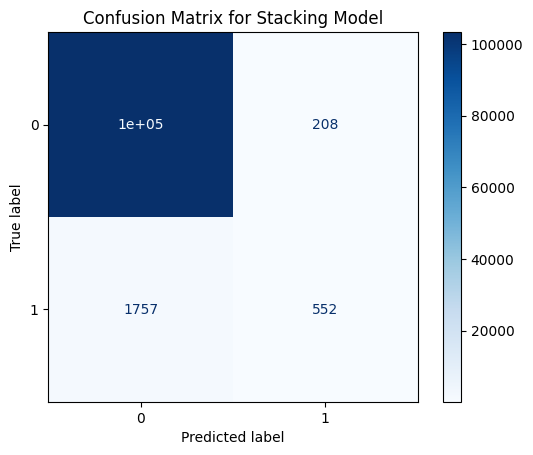

In [ ]:
y_pred = stacking_model.predict(X_test_combined)
y_prob = stacking_model.predict_proba(X_test_combined)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Stacking Model')
plt.show()

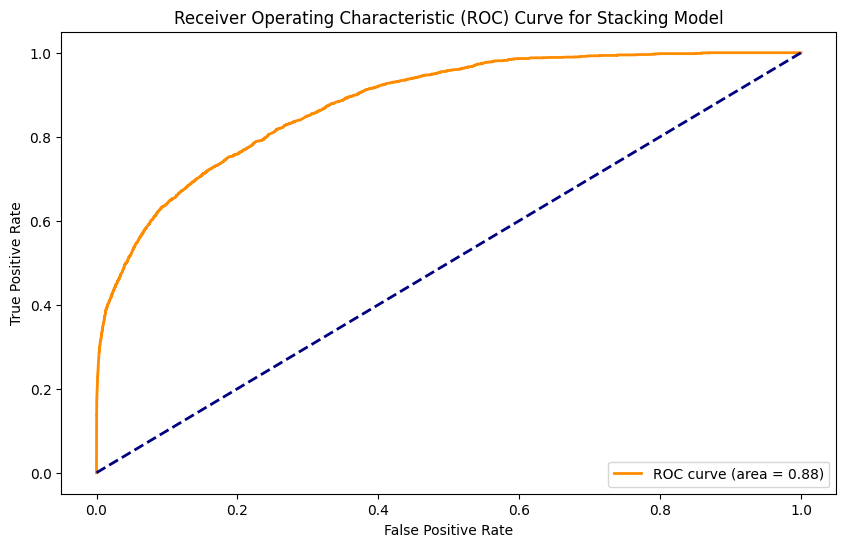

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stacking Model')
plt.legend(loc='lower right')
plt.show()

# --------------------------------------------------------------------------------------

# Voting Model (Don't Run)

In [ ]:
voting_model = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=[0.4, 0.3, 0.3]
)
weight_options = [
    [0.5, 0.3, 0.2],
    [0.6, 0.2, 0.2],
    [0.4, 0.4, 0.2],
    [0.3, 0.3, 0.4],
    [0.3, 0.4, 0.3],
    [0.7, 0.2, 0.1],
    [0.7, 0.1, 0.2]
]

best_score = 0
best_weights = None

# Iterate through different weight options
for weights in weight_options:
    voting_model.set_params(weights=weights)
    scores = cross_val_score(voting_model, X_train_combined, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_weights = weights

print(f"Best Weights: {best_weights} with Accuracy: {best_score:.4f}")

Best Weights: [0.7, 0.2, 0.1] with Accuracy: 0.9813


# --------------------------------------------------------------------------------------

# Repeated Nested Cross Validation (DON'T RUN THEY ARE FINISHED)

In [4]:
def calculate_multi_correlation(X, y):
    """
    Calculate the multi-correlation coefficient between features in X and the target y.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    corr_coefficients = mutual_info_classif(X_scaled, y, random_state=42)
    return corr_coefficients

## Lasso for Feature Selection (DONT RUN)

In [ ]:
# NEW COMMENT: MAKE SURE EACH FOLD HAS SAME DISTRIBUTION OF FRAUD VS NON FRAUD. CORRECT BALANCE 3% (DONE)
# NEW COMMENT: ADD SMOTE ONCE FOLDS ARE ENSURED TO HAVE 3% FRAUD (DONE)
# NEW COMMENT: EVEN IF YOU STRATIFY FOLDS WITH 3 PERCENT FRAUD, CLASSIFIERS MIGHT STILL BE BIASED TO DETECTING ONE CLASS ONLY (DONE)
# NEW COMMENT: PUT MULTI-CORRELATION COEFFICIENT <- FOLLOW THIS (F-STAT/ACCURACY) (DONE)
# NEW COMMENT: TRY ONE CLASS-SVM, DUE TO HIGH UNBALANCED NATURE OF DATASET (NOT DONE)
# NEW COMMENT: Stratify folding, ensure every fold has righ trepresentation, workflow 1: use smote to balance, workflow 2: unbalance with one class classifier, workflow 3: Figure out if balance or dont balance, (NOT DONE)

outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=84)

# Models with Class Weights
xgb_model_2 = XGBClassifier(random_state=42, scale_pos_weight=(97 / 3))  # Adjust weights for XGBoost
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500)

num_features = 450
lower_bound_depth = int(np.floor(np.log2(num_features)))
upper_bound_depth = num_features
depth_range = [lower_bound_depth, lower_bound_depth + 2, int(upper_bound_depth / 2)]

# Parameter grid for RandomizedSearch
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': depth_range,
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize lists to store metrics for each outer fold
outer_accuracy = []
outer_precision = []
outer_recall = []
outer_f1 = []
outer_roc_auc = []
outer_mcc = []

# Outer Loop: Repeated Stratified Cross-Validation
for train_index, test_index in outer_cv.split(X_train, y_train):
    # Split Outer Training and Test Sets
    X_outer_train, X_outer_test = X_train[train_index], X_train[test_index]
    y_outer_train, y_outer_test = y_train[train_index], y_train[test_index]

    # Calculate Multi-Correlation Coefficients
    mcc = calculate_multi_correlation(X_outer_train, y_outer_train)

    # SMOTE to Balance the Classes (Precomputed for efficiency)
    smote = SMOTE(random_state=42, n_jobs=-1)  # Parallel SMOTE if available
    X_outer_train, y_outer_train = smote.fit_resample(X_outer_train, y_outer_train)

    # Feature Selection Using SelectFromModel (faster than LassoCV)
    lasso = LassoCV(cv=inner_cv, random_state=42, n_jobs=-1).fit(X_outer_train, y_outer_train)  # Fewer inner folds
    selected_features = np.where(lasso.coef_ != 0)[0]
    X_outer_train = X_outer_train[:, selected_features]
    X_outer_test = X_outer_test[:, selected_features]

    # Hyperparameter Tuning with RandomizedSearchCV (Reduce Iterations)
    random_search = RandomizedSearchCV(
        estimator=xgb_model_2,
        param_distributions=param_grid,
        n_iter=5,  # Fewer iterations
        scoring='accuracy',
        cv=inner_cv,  # Fewer inner CV folds
        n_jobs=-1,  # Utilize all cores
        random_state=42
    )
    random_search.fit(X_outer_train, y_outer_train)
    best_xgb_model = random_search.best_estimator_

    # Voting Classifier with Tuned XGB Model and Class-Weighted Models
    estimators = [
        ('xgb', best_xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ]
    voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft',
        weights=[0.7, 0.2, 0.1],
        n_jobs=-1  # Parallel voting if supported
    )

    # Train the Voting Model on the Outer Training Set
    voting_model.fit(X_outer_train, y_outer_train)

    # Evaluate the Voting Model on the Outer Test Set
    y_pred = voting_model.predict(X_outer_test)
    y_prob = voting_model.predict_proba(X_outer_test)[:, 1]

    # Calculate Metrics
    outer_accuracy.append(accuracy_score(y_outer_test, y_pred))
    outer_precision.append(precision_score(y_outer_test, y_pred, zero_division=0))
    outer_recall.append(recall_score(y_outer_test, y_pred, zero_division=0))
    outer_f1.append(f1_score(y_outer_test, y_pred, zero_division=0))
    outer_roc_auc.append(roc_auc_score(y_outer_test, y_prob))
    outer_mcc.append(np.corrcoef(y_outer_test, y_pred)[0, 1])

# Print Average Metrics Across All Outer Folds
print(f"Accuracy: {np.mean(outer_accuracy):.4f} ± {np.std(outer_accuracy):.4f}")
print(f"Precision: {np.mean(outer_precision):.4f} ± {np.std(outer_precision):.4f}")
print(f"Recall: {np.mean(outer_recall):.4f} ± {np.std(outer_recall):.4f}")
print(f"F1 Score: {np.mean(outer_f1):.4f} ± {np.std(outer_f1):.4f}")
print(f"ROC-AUC Score: {np.mean(outer_roc_auc):.4f} ± {np.std(outer_roc_auc):.4f}")
print(f"Multi-Correlation Coefficients (MCC): {np.mean(outer_mcc):.4f} ± {np.std(outer_mcc):.4f}")

Accuracy: 0.0214 ± 0.0000
Precision: 0.0214 ± 0.0000
Recall: 1.0000 ± 0.0000
F1 Score: 0.0419 ± 0.0000
ROC-AUC Score: 0.5549 ± 0.0036
Multi-Correlation Coefficients (MCC): nan ± nan


In [ ]:
# Step 5: Final Model Training on the Entire Dataset
# The final voting model is trained on the entire dataset using the selected features
voting_model.fit(X_train[:, selected_features], y_train)

# Step 6: Evaluate the Final Model on the Independent Test Set
# Apply the same feature selection to the independent test set
X_test = np.array(X_test)
X_test_selected = X_test[:, selected_features]
y_final_pred = voting_model.predict(X_test_selected)
y_final_prob = voting_model.predict_proba(X_test_selected)[:, 1]

# Calculate and print final metrics for the independent test set
final_accuracy = accuracy_score(y_test, y_final_pred)
final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)
final_roc_auc = roc_auc_score(y_test, y_final_prob)

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print(f"Final Model Precision: {final_precision:.4f}")
print(f"Final Model Recall: {final_recall:.4f}")
print(f"Final Model F1 Score: {final_f1:.4f}")
print(f"Final Model ROC-AUC Score: {final_roc_auc:.4f}")

Final Model Accuracy: 0.9510
Final Model Precision: 0.0347
Final Model Recall: 0.0463
Final Model F1 Score: 0.0397
Final Model ROC-AUC Score: 0.5725


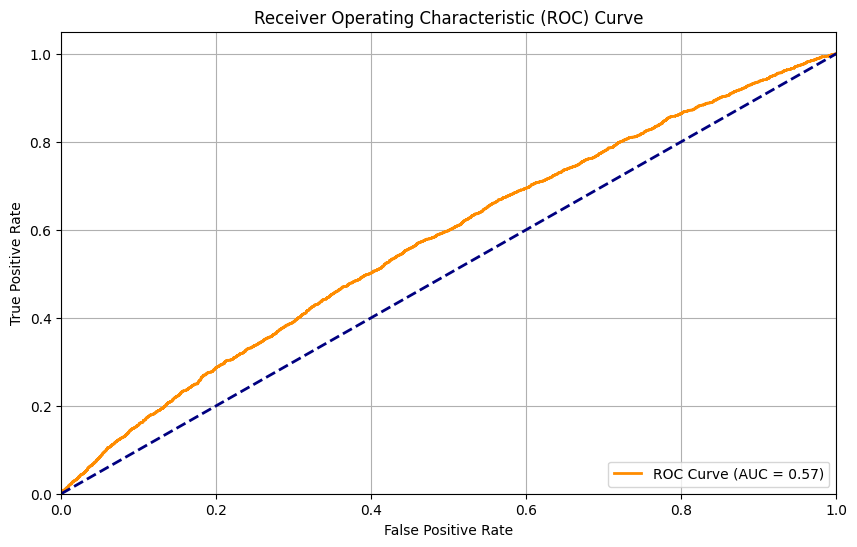

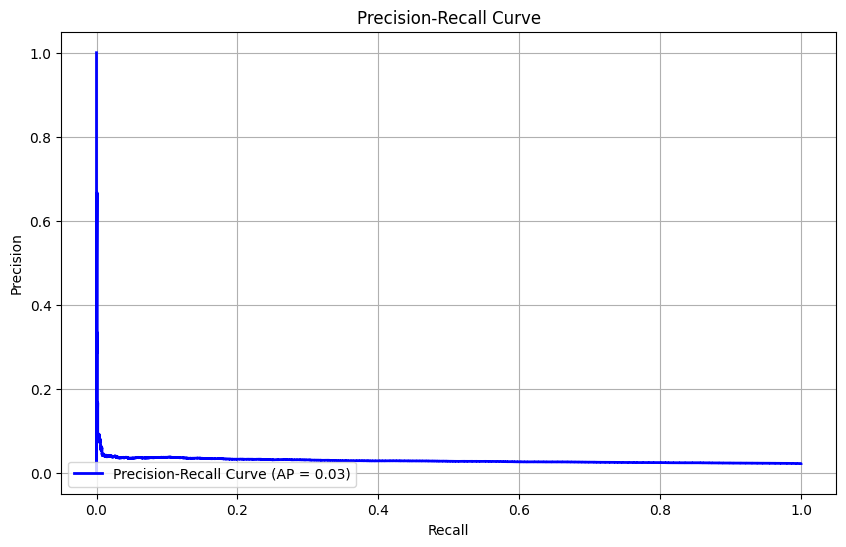

Average Precision Score: 0.0292


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_final_prob)
roc_auc = auc(fpr, tpr)

# Step 2: Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 3: Compute Precision-Recall Curve and Average Precision Score
precision, recall, _ = precision_recall_curve(y_test, y_final_prob)
avg_precision = average_precision_score(y_test, y_final_prob)

# Step 4: Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Step 5: Print Average Precision Score
print(f"Average Precision Score: {avg_precision:.4f}")

In [ ]:
with open('/content/drive/My Drive/IEEE_dataset/voting_model_LASSO.pkl', 'wb') as f:
    pickle.dump(voting_model, f)

#Random Forest Feature Importance For Feature (DON'T RUN)




In [ ]:
# Step 1: Define Outer and Inner Cross-Validation
X_train = np.array(X_train)
y_train = np.array(y_train)
outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=84)

# Step 2: Define Base Models with Class Weights
xgb_model_2 = XGBClassifier(random_state=42, scale_pos_weight=(97 / 3))  # Adjust weights for XGBoost
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
lr_model = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')

# Define parameter grid for RandomizedSearch
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.1],
    'subsample': [0.8]
}

# Initialize metrics storage for outer folds
outer_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'mcc': [], 'multi_corr': []}

# Step 3: Nested Cross-Validation Loop
for train_index, test_index in outer_cv.split(X_train, y_train):
    # Split outer training and test sets
    X_outer_train, X_outer_test = X_train[train_index], X_train[test_index]
    y_outer_train, y_outer_test = y_train[train_index], y_train[test_index]

    # Apply SMOTE to balance classes in the training set
    smote = SMOTE(random_state=42)
    X_outer_train, y_outer_train = smote.fit_resample(X_outer_train, y_outer_train)

    # Calculate Multi-Correlation Coefficient (MCC) for Features and Target
    multi_corr = calculate_multi_correlation(X_outer_train, y_outer_train)
    outer_metrics['multi_corr'].append(np.mean(multi_corr))  # Store average multi-correlation

    # Feature Selection: Use Random Forest Feature Importances
    rf_model.fit(X_outer_train, y_outer_train)
    feature_importances = rf_model.feature_importances_
    selected_features = np.argsort(feature_importances)[-50:]  # Select top 50 features

    # Reduce the training and test sets to selected features
    X_outer_train = X_outer_train[:, selected_features]
    X_outer_test = X_outer_test[:, selected_features]

    # Hyperparameter Tuning with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_model_2,
        param_distributions=param_grid,
        n_iter=3,  # Reduced iterations
        scoring='accuracy',
        cv=inner_cv,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_outer_train, y_outer_train)
    best_xgb_model = random_search.best_estimator_

    # Define the Voting Classifier
    estimators = [
        ('xgb', best_xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ]
    voting_model = VotingClassifier(
        estimators=estimators,
        voting='hard'  # Faster computation
    )

    # Train the voting model on the outer training set
    voting_model.fit(X_outer_train, y_outer_train)

    # Evaluate the voting model on the outer test set
    y_pred = voting_model.predict(X_outer_test)
    y_prob = voting_model.predict_proba(X_outer_test)[:, 1] if hasattr(voting_model, 'predict_proba') else None

    # Store metrics for each outer fold
    outer_metrics['accuracy'].append(accuracy_score(y_outer_test, y_pred))
    outer_metrics['precision'].append(precision_score(y_outer_test, y_pred, zero_division=0))
    outer_metrics['recall'].append(recall_score(y_outer_test, y_pred, zero_division=0))
    outer_metrics['f1'].append(f1_score(y_outer_test, y_pred, zero_division=0))
    if y_prob is not None:
        outer_metrics['roc_auc'].append(roc_auc_score(y_outer_test, y_prob))
    outer_metrics['mcc'].append(matthews_corrcoef(y_outer_test, y_pred))

# Print average metrics across all outer folds
for metric, values in outer_metrics.items():
    if values:  # Skip if metric was not computed
        print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")

# Step 4: Final Model Training on the Entire Dataset
# Use Random Forest Feature Importances for Feature Selection
rf_model.fit(X_train, y_train)
feature_importances_final = rf_model.feature_importances_
selected_features_final = np.argsort(feature_importances_final)[-50:]  # Select top 50 features

#Accuracy: 0.9697 ± 0.0030
#Precision: 0.3311 ± 0.0388
#Recall: 0.3894 ± 0.0216
#F1: 0.3555 ± 0.0148
#Mcc: 0.3426 ± 0.0150
#Multi_corr: 0.1506 ± 0.0007



Accuracy: 0.9697 ± 0.0030
Precision: 0.3311 ± 0.0388
Recall: 0.3894 ± 0.0216
F1: 0.3555 ± 0.0148
Mcc: 0.3426 ± 0.0150
Multi_corr: 0.1506 ± 0.0007


InvalidIndexError: (slice(None, None, None), array([ 83, 442,  21,  16,   9, 347, 336,  48,   8,  17,  40, 370, 122,
       434, 360,  20,  12,  33,  82,  39, 361, 371,  14, 144, 435,  30,
        32,  44,  31, 143,  10, 433,   5, 436, 439,   1,   0, 444, 437,
       441, 443,   4,   2, 440, 446, 445, 447,  29,  28, 448]))

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
# Reduce training and test sets
X_train_selected = X_train[:, selected_features_final]
X_test_selected = X_test.iloc[:, selected_features_final]

# Train the final voting model on the full training set
voting_model.fit(X_train_selected, y_train)

# Evaluate the final model on the independent test set
y_final_pred = voting_model.predict(X_test_selected)
y_final_prob = (
    voting_model.predict_proba(X_test_selected)[:, 1]
    if hasattr(voting_model, 'predict_proba')
    else None
)

# Calculate and print final metrics
final_accuracy = accuracy_score(y_test, y_final_pred)
final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)
final_roc_auc = roc_auc_score(y_test, y_final_prob) if y_final_prob is not None else None

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print(f"Final Model Precision: {final_precision:.4f}")
print(f"Final Model Recall: {final_recall:.4f}")
print(f"Final Model F1 Score: {final_f1:.4f}")
if final_roc_auc is not None:
    print(f"Final Model ROC-AUC Score: {final_roc_auc:.4f}")

Final Model Accuracy: 0.9874
Final Model Precision: 0.8227
Final Model Recall: 0.5366
Final Model F1 Score: 0.6495


In [ ]:
with open('/content/drive/My Drive/IEEE_dataset/voting_model_RandomForest.pkl', 'wb') as f:
    pickle.dump(voting_model, f)

# ONE CLASS SVM REPEATED NESTED CROSS-VALIDATION

In [6]:
#A basic rule of thumb is briefly covered in NTU's practical guide
#to support vector classification (Appendix C).
#If the number of features is large, one may not need to map
#data to a higher dimensional space. That is, the nonlinear mapping does
#not improve the performance. Using the linear kernel is good enough
#- https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
import numpy as np

# Initialize metrics storage for outer folds
outer_metrics_svm = {
    'accuracy': [], 'precision': [], 'recall': [],
    'f1': [], 'roc_auc': [], 'multi_corr': []
}

# List to store models for each fold
svm_models = []

# Outer Cross-Validation
outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)

# Apply PCA to reduce dimensions globally (if needed)
pca = PCA(n_components=50)  # Keep top 50 components
X_train_pca = pca.fit_transform(X_train)

# Outer Loop for Cross-Validation
for train_index, test_index in outer_cv.split(X_train_pca, y_train):
    # Split Outer Training and Test Sets
    X_outer_train, X_outer_test = X_train_pca[train_index], X_train_pca[test_index]
    y_outer_train, y_outer_test = y_train.iloc[train_index], y_train.iloc[test_index]


    # Subsample Majority Class (Non-Fraud) for Training
    X_train_majority = X_outer_train[y_outer_train == 0]  # Retain non-fraud
    X_train_majority = resample(X_train_majority, n_samples=50000, random_state=42)  # Subsample to 50,000 samples

    # Train One-Class SVM
    one_class_svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
    one_class_svm.fit(X_train_majority)

    # Store the trained model
    svm_models.append(one_class_svm)

    # Predict Anomalies on the Test Set
    y_pred_scores = one_class_svm.decision_function(X_outer_test)  # Higher = more normal
    y_pred = one_class_svm.predict(X_outer_test)

    # Convert One-Class SVM predictions to binary labels
    y_pred_binary = (y_pred == -1).astype(int)  # Convert -1 to 1 (fraud)

    # Calculate Multi-Correlation Coefficient
    multi_corr = calculate_multi_correlation(X_outer_test, y_outer_test)
    outer_metrics_svm['multi_corr'].append(np.mean(multi_corr))  # Store average multi-correlation

    # Evaluate Performance
    accuracy = accuracy_score(y_outer_test, y_pred_binary)
    precision = precision_score(y_outer_test, y_pred_binary, zero_division=0)
    recall = recall_score(y_outer_test, y_pred_binary, zero_division=0)
    f1 = f1_score(y_outer_test, y_pred_binary, zero_division=0)
    roc_auc = roc_auc_score(y_outer_test, y_pred_scores)

    # Store metrics
    outer_metrics_svm['accuracy'].append(accuracy)
    outer_metrics_svm['precision'].append(precision)
    outer_metrics_svm['recall'].append(recall)
    outer_metrics_svm['f1'].append(f1)
    outer_metrics_svm['roc_auc'].append(roc_auc)

# Print average metrics across all outer folds
print("One-Class SVM Metrics:")
for metric, values in outer_metrics_svm.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")


One-Class SVM Metrics:
Accuracy: 0.8832 ± 0.0014
Precision: 0.0236 ± 0.0013
Recall: 0.1104 ± 0.0056
F1: 0.0389 ± 0.0021
Roc_auc: 0.4617 ± 0.0046
Multi_corr: 0.0018 ± 0.0001


In [7]:
model_path = '/content/drive/My Drive/IEEE_dataset/one_class_svm_models.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(svm_models, f)